In [2]:
import pandas as pd

df = pd.read_csv('train_data.csv')
print(df.head())

from sklearn.model_selection import train_test_split

target = '평점'
features = ['개봉일', '감독', '국가', '장르', '개봉일'] 

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                                 제목                             감독  \
0              Dick Johnson Is Dead                Kirsten Johnson   
1  My Little Pony: A New Generation  Robert Cullen, José Luis Ucha   
2                      The Starling                 Theodore Melfi   
3                      Je Suis Karl            Christian Schwochow   
4  Confessions of an Invisible Girl                  Bruno Garotti   

                        국가                                  장르         개봉일  \
0            United States                       Documentaries  2020-01-23   
1                      NaN            Children & Family Movies  2021-09-22   
2            United States                    Comedies, Dramas  2021-09-17   
3  Germany, Czech Republic        Dramas, International Movies  2021-09-16   
4                      NaN  Children & Family Movies, Comedies  2021-09-22   

      평점  
0  7.100  
1  7.700  
2  6.900  
3  5.296  
4  6.682  


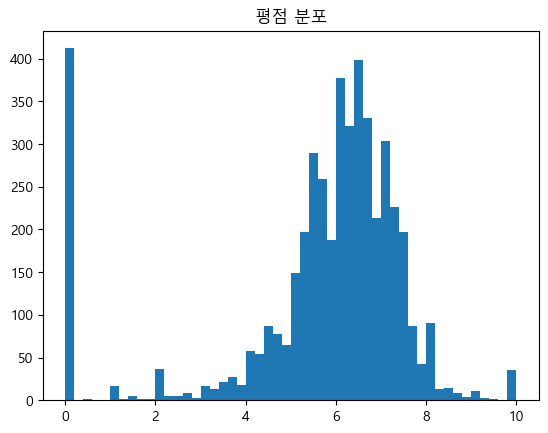

평점 0 개수: 412
제거 후 데이터 크기: (4281, 6)


In [3]:
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font_name)

plt.hist(df['평점'], bins=50)
plt.title('평점 분포')
plt.show()

zero_count = (df['평점'] == 0).sum()
print(f"평점 0 개수: {zero_count}")

df_filtered = df[df['평점'] > 0].copy()
print(f"제거 후 데이터 크기: {df_filtered.shape}")

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("train_data.csv")
df = df.loc[:, ~df.columns.duplicated()]

df = df[df['평점'] > 0].copy()

df['개봉일'] = pd.to_datetime(df['개봉일'], errors='coerce')
df['개봉요일'] = df['개봉일'].dt.dayofweek
df['개봉연도'] = df['개봉일'].dt.year
df['개봉월'] = df['개봉일'].dt.month
df['주말여부'] = df['개봉요일'].apply(lambda x: 1 if x >= 5 else 0)

def month_to_season(month):
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'
    
df['계절'] = df['개봉월'].apply(month_to_season)
df = pd.get_dummies(df, columns=['계절'])

df = df.drop(columns=['개봉일'])

df['장르_str'] = df['장르'].fillna('').apply(lambda x: x.replace(',', ' '))
tfidf = TfidfVectorizer()
genre_tfidf = tfidf.fit_transform(df['장르_str'])
genre_tfidf_df = pd.DataFrame(genre_tfidf.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)
df = df.drop(columns=['장르', '장르_str'])
df = pd.concat([df, genre_tfidf_df], axis=1)

for col in ['감독', '국가']:
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df = df.dropna()

X = df.drop(columns=['평점', '제목'])
y = df['평점']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target_enc = ce.TargetEncoder(cols=['감독', '국가'])
X_train = target_enc.fit_transform(X_train, y_train)
X_test = target_enc.transform(X_test)

param_dist = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [1500, 2000, 2500], 
    'subsample': [0.8, 1],  
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1, 0.5], 
    'reg_lambda': [1, 1.5],
    'min_child_weight': [1, 3, 5], 
    'gamma': [0, 1], 
}

base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=50),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)
print("Best params:", search.best_params_)

best_model = search.best_estimator_
best_model = xgb.XGBRegressor(
    **search.best_params_,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R^2: {train_r2:.4f}")

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R^2: {r2:.4f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:1.21851
[1]	validation_0-rmse:1.21760
[2]	validation_0-rmse:1.21672
[3]	validation_0-rmse:1.21542
[4]	validation_0-rmse:1.21442
[5]	validation_0-rmse:1.21359
[6]	validation_0-rmse:1.21292
[7]	validation_0-rmse:1.21212
[8]	validation_0-rmse:1.21156
[9]	validation_0-rmse:1.21093
[10]	validation_0-rmse:1.20985
[11]	validation_0-rmse:1.20917
[12]	validation_0-rmse:1.20845
[13]	validation_0-rmse:1.20785
[14]	validation_0-rmse:1.20741
[15]	validation_0-rmse:1.20655
[16]	validation_0-rmse:1.20618
[17]	validation_0-rmse:1.20566
[18]	validation_0-rmse:1.20515
[19]	validation_0-rmse:1.20483
[20]	validation_0-rmse:1.20441
[21]	validation_0-rmse:1.20409
[22]	validation_0-rmse:1.20376
[23]	validation_0-rmse:1.20351
[24]	validation_0-rmse:1.20329
[25]	validation_0-rmse:1.20246
[26]	validation_0-rmse:1.20223
[27]	validation_0-rmse:1.20201
[28]	validation_0-rmse:1.20150
[29]	validation_0-rmse:1.20129
[30]	validation_0-

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(**search.best_params_, objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42, verbose=0)

xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_valid)
pred_lgb = lgb_model.predict(X_valid)
pred_cat = cat_model.predict(X_valid)

pred_ensemble_weighted = (
    0.6 * pred_xgb +
    0.3 * pred_lgb + 
    0.1 * pred_cat
)

mse = mean_squared_error(y_valid, pred_ensemble_weighted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, pred_ensemble_weighted)
r2 = r2_score(y_valid, pred_ensemble_weighted)

print("Weighted Ensemble Validation RMSE:", round(rmse, 4))
print("Weighted Ensemble Validation MAE:", round(mae, 4))
print("Weighted Ensemble Validation R^2:", round(r2, 4))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 3424, number of used features: 37
[LightGBM] [Info] Start training from score 6.190443
Weighted Ensemble Validation RMSE: 1.1584
Weighted Ensemble Validation MAE: 0.8501
Weighted Ensemble Validation R^2: 0.0913


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

best_rmse = float('inf')
best_weights = None
best_metrics = {}

for a, b, c in weights:
    pred_ensemble = a * pred_xgb + b * pred_lgb + c * pred_cat
    mse = mean_squared_error(y_valid, pred_ensemble)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, pred_ensemble)
    r2 = r2_score(y_valid, pred_ensemble)

    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = (a, b, c)
        best_metrics = {
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }

print(f"최적 가중치: XGB={best_weights[0]}, LGB={best_weights[1]}, CAT={best_weights[2]}")
print(f"Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"Best MAE: {best_metrics['MAE']:.4f}")
print(f"Best R2 : {best_metrics['R2']:.4f}")


최적 가중치: XGB=0.3, LGB=0.4, CAT=0.3
Best RMSE: 1.1575
Best MAE: 0.8489
Best R2 : 0.0926


In [30]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

models = {
    "xgb": xgb_model,
    "lgb": lgb_model,
    "cat": cat_model
}

oof_preds = np.zeros((X_valid.shape[0], len(models)))

for i, (name, model) in enumerate(models.items()):
    oof_preds[:, i] = model.predict(X_valid)

meta_model = Ridge(alpha=1.0)
meta_model.fit(oof_preds, y_valid)

final_preds = meta_model.predict(oof_preds)

mse = mean_squared_error(y_valid, final_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, final_preds)
r2 = r2_score(y_valid, final_preds)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)



RMSE: 1.1511801448195442
MAE : 0.8477754363270226
R2  : 0.10255733788290244


##### 튜닝 실패들

In [33]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros((X_train.shape[0], 3)) 
test_preds = np.zeros((X_test.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold+1}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # XGBoost
    model_xgb = XGBRegressor(**search.best_params_, objective='reg:squarederror', random_state=42)
    model_xgb.fit(X_tr, y_tr)
    oof_preds[val_idx, 0] = model_xgb.predict(X_val)
    test_preds[:, 0] += model_xgb.predict(X_test) / n_splits
    
    # LightGBM
    model_lgb = lgb.LGBMRegressor(random_state=42)
    model_lgb.fit(X_tr, y_tr)
    oof_preds[val_idx, 1] = model_lgb.predict(X_val)
    test_preds[:, 1] += model_lgb.predict(X_test) / n_splits
    
    # CatBoost
    model_cat = CatBoostRegressor(random_state=42, verbose=0)
    model_cat.fit(X_tr, y_tr)
    oof_preds[val_idx, 2] = model_cat.predict(X_val)
    test_preds[:, 2] += model_cat.predict(X_test) / n_splits

# 메타 모델 XGBRegressor
meta_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
)
meta_model.fit(oof_preds, y_train)

final_preds = meta_model.predict(test_preds)

rmse = mean_squared_error(y_test, final_preds) ** 0.5
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

print(f"Stacking Validation RMSE: {rmse:.4f}")
print(f"Stacking Validation MAE: {mae:.4f}")
print(f"Stacking Validation R^2: {r2:.4f}")

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 2739, number of used features: 37
[LightGBM] [Info] Start training from score 6.199327
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 2739, number of used features: 37
[LightGBM] [Info] Start training from score 6.194414
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 2739, number of used features: 37
[LightGBM

In [12]:
y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R^2: {train_r2:.4f}")

Train RMSE: 0.6222
Train R^2: 0.7423


In [7]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses = []

for train_idx, val_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.6,
        reg_alpha=0.5,
        reg_lambda=1.5,
        random_state=42,
        tree_method='hist', 
        early_stopping_rounds=100,
        verbosity=0
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmses.append(rmse)
    print(f'Fold RMSE: {rmse:.4f}')

print(f'CV 평균 RMSE: {np.mean(rmses):.4f}')


[0]	validation_0-rmse:1.21867


[100]	validation_0-rmse:1.18451
[200]	validation_0-rmse:1.17234
[300]	validation_0-rmse:1.16609
[400]	validation_0-rmse:1.16337
[500]	validation_0-rmse:1.16180
[600]	validation_0-rmse:1.16090
[700]	validation_0-rmse:1.16004
[800]	validation_0-rmse:1.15989
[900]	validation_0-rmse:1.15876
[960]	validation_0-rmse:1.15906
Fold RMSE: 1.1587
[0]	validation_0-rmse:1.24228
[100]	validation_0-rmse:1.22134
[200]	validation_0-rmse:1.21604
[300]	validation_0-rmse:1.21466
[400]	validation_0-rmse:1.21403
[500]	validation_0-rmse:1.21341
[556]	validation_0-rmse:1.21444
Fold RMSE: 1.2131
[0]	validation_0-rmse:1.24779
[100]	validation_0-rmse:1.21978
[200]	validation_0-rmse:1.21058
[300]	validation_0-rmse:1.20634
[400]	validation_0-rmse:1.20306
[500]	validation_0-rmse:1.20143
[600]	validation_0-rmse:1.20095
[700]	validation_0-rmse:1.20002
[800]	validation_0-rmse:1.19944
[900]	validation_0-rmse:1.19957
[911]	validation_0-rmse:1.19972
Fold RMSE: 1.1993
[0]	validation_0-rmse:1.19648
[100]	validation_0-rmse:

In [8]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 2000),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'hist'
    }
    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    return -scores.mean()

    
    model = xgb.XGBRegressor(**params)
    
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:", study.best_trial.params)


c:\Users\USER\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-01 06:29:40,749] A new study created in memory with name: no-name-c3b6bc59-afa8-4749-81c5-9e71059e22ce
[I 2025-08-01 06:29:42,636] Trial 0 finished with value: 0.6949528372621879 and parameters: {'max_depth': 6, 'learning_rate': 0.028849906690707458, 'n_estimators': 1382, 'subsample': 0.743315459914803, 'colsample_bytree': 0.6037033249905063, 'reg_alpha': 0.056968264531542835, 'reg_lambda': 1.3285587120698144, 'min_child_weight': 6, 'gamma': 0.6068740255049239}. Best is trial 0 with value: 0.6949528372621879.
[I 2025-08-01 06:29:44,644] Trial 1 finished with value: 0.6929913911440747 and parameters: {'max_depth': 6, 'learning_rate': 0.01359592536450595, 'n_estimators': 1267, 'subsample': 0.8083295394257786, 'colsample_bytree': 0.965

Best trial: {'max_depth': 3, 'learning_rate': 0.010247122835573092, 'n_estimators': 1748, 'subsample': 0.9480708693930231, 'colsample_bytree': 0.7281717172265134, 'reg_alpha': 0.06289738805523748, 'reg_lambda': 0.7950405375101203, 'min_child_weight': 6, 'gamma': 0.8564057766595191}


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 3,
    'learning_rate': 0.010247122835573092,
    'n_estimators': 1748,
    'subsample': 0.9480708693930231,
    'colsample_bytree': 0.7281717172265134,
    'reg_alpha': 0.06289738805523748,
    'reg_lambda': 0.7950405375101203,
    'min_child_weight': 6,
    'gamma': 0.8564057766595191,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
    params,
    dtrain,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=100
)

y_pred = model.predict(dtest)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse:.4f}')
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R^2: {r2:.4f}")


[0]	train-rmse:1.21695	eval-rmse:1.21853
[9]	train-rmse:1.17162	eval-rmse:1.21204
Test RMSE: 1.2120
Validation MAE: 0.9457
Validation R^2: -0.1264


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [06:34:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


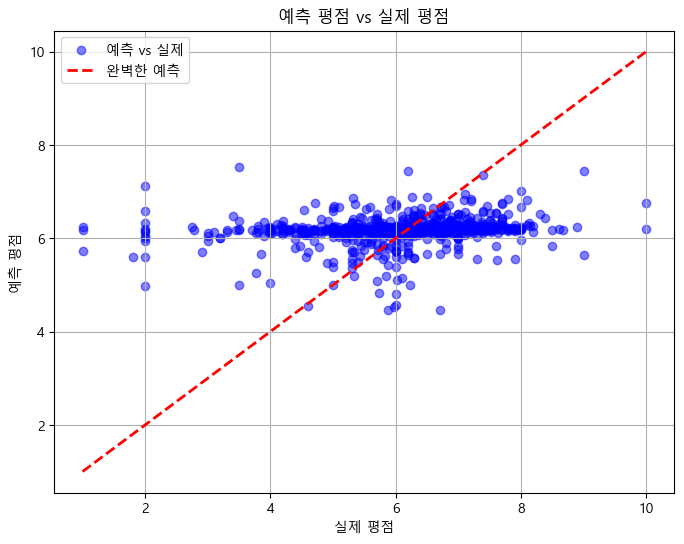

In [ ]:
#그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='예측 vs 실제')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='완벽한 예측')
plt.xlabel('실제 평점')
plt.ylabel('예측 평점')
plt.title('예측 평점 vs 실제 평점')
plt.legend()
plt.grid(True)
plt.show()